In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **Explore Data**

In [ ]:
df=pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
df.head()

In [ ]:
df.isnull().sum()

**Observation 1**
1. Data has no numeric values.
2. TV shows have a duration in "Seasons" and movies has in "Minutes".
3. Cast and Listed_in columns have many names for every show/movies.


# **TV shows VS Movies**

In [ ]:
df.pivot_table('show_id',index='release_year',columns='type',aggfunc='count').plot(figsize=(7, 7))

In [ ]:
df.groupby('type').count()

In [ ]:
#Removing "Seasons/Season/Minutes" from duration so that we can convert it in numeric values

df['duration']=df['duration'].str.replace(' Seasons', "", case = False) 
df['duration']=df['duration'].str.replace(' Season', "", case = False) 
df['duration']=df['duration'].str.replace(' min', "", case = False) 
df['duration']=df['duration'].astype(int)

#We need to convert TV Show/Movies in same unit of time(Hour) so that we can compare them

index = df.index[df["type"] == "TV Show"]
df.loc[index,'duration'] = df['duration']*40*10 #I'm assuming every season has 10 episode and each episode is of 40 min.
df["show_id"] = df.index
df.groupby('type')['duration'].sum()//60 # Converting Minutes value into hours


We have lots  of values in the Rating Column. We can divide them into 3 categories based on United States's Rating format i.e ***Maturity ratings and classifications on Netflix***. This Data is available on Netflix's site Link- [https://help.netflix.com/en/node/2064/us](http://)

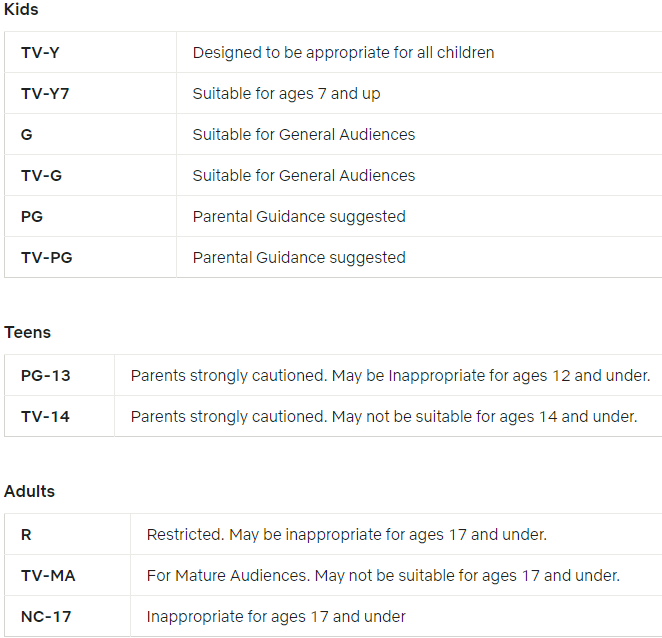

In [ ]:
d={'TV-Y':"Kid", 'TV-Y7':"Kid", 'G':"Kid", 'TV-G':"Kid", 'PG':"Kid", 'TV-PG':"Kid",'PG-13':"Teen", 'TV-14':"Teen",'TV-MA':"Adults",'R':"Adults",'NC-17':"Adults"}
df['Maturity']=df['rating'].map(d)
df.pivot_table('rating',index='type',columns='Maturity',aggfunc='count').plot(kind='bar',figsize=(7, 7))

**Observation 2**
1. Most of the movies have been released after 2010
2. There are more movies than TV shows but still TV shows has more hours.
3. There are lots of adults movies available. Incase of TV shows it is almost the same.

# Task : Netflix Orginal vs Licensed

If a movie/show is created by netflix(orginal) it will directly be released on Netflix and if it is Licensed Netflix has to buy it means there will be time difference between released date and added date 

In [ ]:
new= df["date_added"].str.split(",", n = 1, expand = True) # we need year part of date only
df['added_date']=new[1]
df['added_date'].fillna(0,inplace=True)
df['added_date']=df['added_date'].astype(int)
df['release_year']=df['release_year'].astype(int)
df['Orginal vs Licensed']= df['release_year']==df['added_date'] #comparing both release year and added date
d = {True: 'Orginal', False: 'Licensed'}
df['Orginal vs Licensed']=df['Orginal vs Licensed'].map(d)

df.pivot_table('show_id',index='Maturity',columns='Orginal vs Licensed',aggfunc='count').plot(kind='bar',figsize=(7, 7))

# **Top 5 in Different features**

There are different features like Director, Country, Cast and Listed_in
Director and Country has **single** values in it and Cast and Listed_in has **multiple** values
We will create a function that can show us the top 5 in each of the features.


In [ ]:
# For Single Values like Director and Country
def TopCalulatorForSingle(a):
    df[a].value_counts().head(5).plot(kind='barh',figsize=(7, 7))
    plt.xlabel("No of TV show/Movies", labelpad=14)
    plt.ylabel(a, labelpad=14)
    plt.title("Top 5", y=1.02);

    
from collections import Counter 

# For Multiple Values like Listed_in and Cast

def TopCalulatorForMultiple(a):
    l=list()
    for i in df[a].dropna(): #We can drop null values because it will be unfair to replace it with sommeone else name
        for j in i.split(','):
            l.append(j.strip())
    d = Counter(l) 
    df_new=pd.DataFrame(d.items(), columns=['Category', 'Count'])
    return df_new.sort_values(by=['Count'],ascending=False).head(5)


In [ ]:
TopCalulatorForSingle('country')


In [ ]:
TopCalulatorForSingle('director')

In [ ]:
TopCalulatorForMultiple('cast')

In [ ]:
TopCalulatorForMultiple('listed_in')

**Observation 3**
1. US has the highest number of movies/shows. 2nd highest in India but it's not even half of the US.
2. Although US has the highest number of movies/shows, All the top actors with the highest number of movies are from India. 
3. It is strange that there is no one from India in Top Director.
4. We have no information to show if the actors are in the Lead role or the supporting role.
5. People are enjoying more Dramas and Comedies.

# Sentimental Analysis

From the description, we will try to find sentiment, based on the score we can categorise it between Positive, Negative and Neutral.

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def get_sentiment(row, **kwargs):

    sentiment_score = sid.polarity_scores(row)
    positive_meter = round((sentiment_score['pos'] * 10), 2)
    negative_meter = round((sentiment_score['neg'] * 10), 2)
    if abs(positive_meter-negative_meter) <1:
        return 'Neutral'
    else:
        if positive_meter>negative_meter:
            return 'Poitive'
        else:
            return 'Negative'

        
df['sentiment'] = df['description'].apply(get_sentiment)

In [ ]:
df.pivot_table('show_id',index='Maturity',columns='sentiment',aggfunc='count').plot(kind='bar',figsize=(7, 7))

**Observation 4**

1. It's good to see that Kids has more positive content and very less of negative content.
2. With the increase in maturity content get more balance between the 3 categories.